In [2]:
import sys
sys.path.append("/home/sanketh/vqr/")
%load_ext autoreload
%autoreload 2

from experiments.data.mvn import LinearMVNDataProvider

n = 10000
k = 2
d = 2
data_provider = LinearMVNDataProvider(d=d, k=k, seed=42)
X, Y = data_provider.sample(n=n)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from vqr.solvers.dual.regularized_lse import RegularizedDualVQRSolver
from vqr.api import VectorQuantileRegressor

epsilon = 1e-4
num_epochs = 10000
T = 10

solver = RegularizedDualVQRSolver(
    verbose=True,
    num_epochs=num_epochs,
    epsilon=epsilon,
    lr=2.9,
    gpu=True,
    full_precision=False,
    lr_factor=0.9,
    lr_patience=500,
    lr_threshold=0.5 * 0.01,
)

vqr = VectorQuantileRegressor(n_levels=T, solver=solver)
vqr.fit(X, Y)

  0%|                                                                 | 0/10000 [00:00<?, ?epochs/s]

VectorQuantileRegressor(n_levels=10, solver=RegularizedDualVQRSolver(eps=1e-02))

In [8]:
import numpy as np

def get_monotonicity(cond_X, refine: bool = False):
    levels = np.stack([level.ravel() for level in vqr.quantile_grid])
    quantiles = np.stack([quantile.ravel() for quantile in vqr.vector_quantiles(cond_X, refine)[0]])
    pairwise_levels = (levels.reshape(d, 1, T**d) - levels.reshape(d, T**d, 1)).reshape(d, T**(2*d))
    pairwise_quantiles = (quantiles.reshape(d, 1, T**d) - quantiles.reshape(d, T**d, 1)).reshape(d, T**(2*d))
    all_pairs_inner_prod = np.sum(pairwise_levels*pairwise_quantiles, axis=0).reshape(T**d, T**d)
    return all_pairs_inner_prod

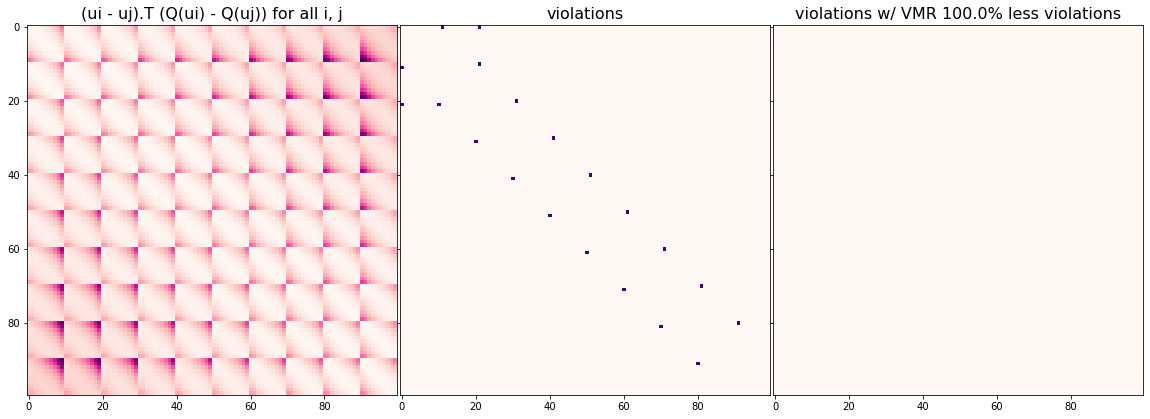

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt, cm
import random

fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111, nrows_ncols = (1,3), axes_pad = 0.05, cbar_location = "top",)
idx = random.randint(a=0, b=n)
all_pairs = get_monotonicity(cond_X=X[[idx]], refine=False)
all_pairs_refined = get_monotonicity(cond_X=X[[idx]], refine=True)
frac_violations_comp_unrefined = np.sum(all_pairs_refined<0)/np.sum(all_pairs<0)
all_pairs_plt = grid[0].imshow(all_pairs, cmap=cm.RdPu)
grid[0].set_title("(ui - uj).T (Q(ui) - Q(uj)) for all i, j", fontsize=16)
grid[1].imshow(all_pairs < 0, cm.RdPu)
grid[1].set_title("violations", fontsize=16)
grid[2].imshow(all_pairs_refined < 0, cm.RdPu)
grid[2].set_title(f"violations w/ VMR {(1-frac_violations_comp_unrefined)*100:.1f}% less violations", fontsize=16)
plt.savefig(f"/home/sanketh/vqr/notebooks/VMR_{d=}_{T=}_{epsilon=}.png", bbox_inches = 'tight')

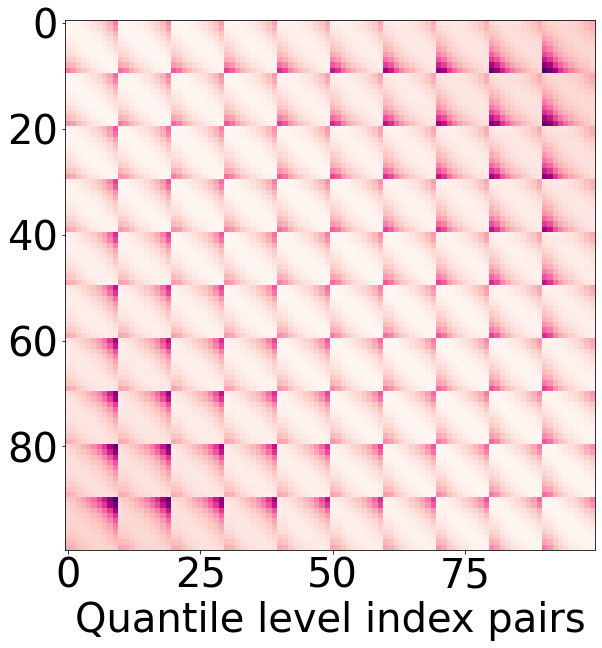

In [30]:
import matplotlib as mpl
import os

OUT_DIR_PATH = "../out/vmr2d/"
os.makedirs(OUT_DIR_PATH, exist_ok=True)

mpl.rcParams["font.size"] = 40

plt.figure(figsize=(10, 10))
plt.imshow(all_pairs, cmap=cm.RdPu)
plt.xlabel(r"Quantile level index pairs", fontsize=40)
plt.tight_layout()
plt.savefig(OUT_DIR_PATH+"monotonicity-allpairs.png", dpi=300)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(all_pairs<0, cmap=cm.RdPu)
plt.xlabel(r"Quantile level index pairs", fontsize=40)
plt.tight_layout()
plt.savefig(OUT_DIR_PATH+"monotonicity-violations.png", dpi=300)